## AI电力能耗预测大赛实现案例

### 小提示
对于python的库和函数不熟悉的同学，可以百度搜索，也可以通过系统内置的help函数来查询哦。

In [1]:
import pandas as pd
help(pd)

Help on package pandas:

NAME
    pandas

FILE
    /usr/local/lib/python2.7/dist-packages/pandas/__init__.py

DESCRIPTION
    pandas - a powerful data analysis and manipulation library for Python
    
    **pandas** is a Python package providing fast, flexible, and expressive data
    structures designed to make working with "relational" or "labeled" data both
    easy and intuitive. It aims to be the fundamental high-level building block for
    doing practical, **real world** data analysis in Python. Additionally, it has
    the broader goal of becoming **the most powerful and flexible open source data
    analysis / manipulation tool available in any language**. It is already well on
    its way toward this goal.
    
    Main Features
    -------------
    Here are just a few of the things that pandas does well:
    
      - Easy handling of missing data in floating point as well as non-floating
        point data
      - Size mutability: columns can be inserted and deleted from Da

## 案例背景介绍

![](https://work.alibaba-inc.com/aliwork_tfs/g01_alibaba-inc_com/tfscom/TB1oAMfQFXXXXX1XVXXXXXXXXXX.tfsprivate.jpg)

案例数据来源于江苏镇江扬中市的高新区企业历史近2年的用电量，希望能够根据历史数据去精准预测未来一个月每一天的用电量，这是一个很典型的回归类问题，和我们的流量预测非常相关，我们来看看如何用数据驱动的方式去完成这样一个预测。

### 载入数据集合并

In [1]:
import numpy as np
import pandas as pd

_df = pd.read_csv("./input/zhenjiang_power.csv")
df_201609 = pd.read_csv("./input/zhenjiang_power_9.csv")
train_df = pd.concat([_df, df_201609])

### 数据一览
数据会被读取成Excel一样行与列的形式。其中每一行是一个样本(一条历史记录)，每一列可以是一个指代特征(对最后结果有贡献的数据因素/维度)

In [2]:
train_df.head(5)

,power_consumption,record_date,user_id
0,1135.0,2015-01-01,1
1,570.0,2015-01-02,1
2,3418.0,2015-01-03,1
3,3968.0,2015-01-04,1
4,3986.0,2015-01-05,1


每一行是一条用电记录(一个企业一天一条记录)，每一列是不同的数据维度信息，第一列是用电量，第二列是日期，第三列是企业id

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null object
user_id              929106 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.4+ MB


In [4]:
train_df.describe()

,power_consumption,user_id
count,9.291060e+05,929106.000000
mean,2.617557e+03,727.500000
std,3.141672e+04,419.733772
min,1.000000e+00,1.000000
25%,4.400000e+01,364.000000
50%,2.630000e+02,727.500000
75%,8.280000e+02,1091.000000
max,1.310016e+06,1454.000000


In [6]:
train_df.shape

(929106, 3)

### 日期字段格式转化
我们把字符串形式标示的日期列，转换成计算机能理解的日期格式，这样能方便取出对结果预测有帮助的相关信息(比如这一天是星期几，一个月的第几天，是否是工作日...)

In [5]:
train_df['record_date'] = pd.to_datetime(train_df['record_date'])

In [5]:
train_df.head()

,power_consumption,record_date,user_id
0,1135.0,2015-01-01,1
1,570.0,2015-01-02,1
2,3418.0,2015-01-03,1
3,3968.0,2015-01-04,1
4,3986.0,2015-01-05,1


### 数据汇总聚合
最终的目标是对每一天的用电量去进行预测，给定的数据是按小时维度拆分的，我们有不同的处理方式，简单的处理方式是对数据按天做一个汇总，用pandas做相关操作如下：

In [10]:
train_df = train_df[['record_date','power_consumption']].groupby(by='record_date').agg('sum')
train_df = train_df.reset_index()
train_df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


### 添加测试数据
我们要预测下一个月的每天用电量，我们从历史数据上用算法总结出来规律/模式以后，要把对应的规律/模式应用在未来的时间段进行预测，我们先生成未来的部分特征数据(这里主要是日期)

In [11]:
test_df = pd.date_range('2016-10-1', periods=31, freq='D')
test_df = pd.DataFrame(test_df)
test_df.columns = ['record_date']
test_df['power_consumption'] = 0

In [12]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,0
3,2016-10-04,0
4,2016-10-05,0


### 拼成总体数据
我们把训练集和测试集拼接在一起，方便做一些统一的数据处理。（比如用电量一个很重要的因素是历史用电量，这个信息我们需要去做汇总计算和设置）

In [13]:
total_df = pd.concat([train_df, test_df])

In [14]:
total_df.tail()

,record_date,power_consumption
26,2016-10-27,0.0
27,2016-10-28,0.0
28,2016-10-29,0.0
29,2016-10-30,0.0
30,2016-10-31,0.0


### 构造和时间相关的强特征
构造出一些强时间指代特征
* 一周中的第几天(星期几)
* 一个月中的第几天(月初还是月末的信息)
* 一年中的第几天(年中年末等时间信息)
* 一年中第几个月(季节相关的信息，季节会影响气温和用电)，哪一年。

In [15]:
total_df['day_of_week'] = total_df['record_date'].apply(lambda x: x.dayofweek)
total_df['day_of_month'] = total_df['record_date'].apply(lambda x: x.day)
total_df['day_of_year'] = total_df['record_date'].apply(lambda x: x.dayofyear)
total_df['month_of_year'] = total_df['record_date'].apply(lambda x: x.month)
total_df['year'] = total_df['record_date'].apply(lambda x: x.year)

In [18]:
total_df.head()

,record_date,power_consumption,day_of_week,day_of_month,day_of_year,month_of_year,year
0,2015-01-01,2900575.0,3,1,1,1,2015
1,2015-01-02,3158211.0,4,2,2,1,2015
2,2015-01-03,3596487.0,5,3,3,1,2015
3,2015-01-04,3939672.0,6,4,4,1,2015
4,2015-01-05,4101790.0,0,5,5,1,2015


### 添加周末特征信息
添加工作日还是周末的信息，周六周日和工作日的用电量显然是不一样的(大家可以简单做一个数据统计就可以看出来)，这种时间维度的特征在我们流量的预测上同样有用哦！

In [19]:
total_df['holiday'] =0
total_df['holiday_sat'] =0
total_df['holiday_sun'] =0

total_df.loc[total_df.day_of_week==5,'holiday'] = 1
total_df.loc[total_df.day_of_week==5,'holiday_sat'] = 1

total_df.loc[total_df.day_of_week==6,'holiday'] = 1
total_df.loc[total_df.day_of_week==6,'holiday_sun'] = 1

In [20]:
total_df.head()

,record_date,power_consumption,day_of_week,day_of_month,day_of_year,month_of_year,year,holiday,holiday_sat,holiday_sun
0,2015-01-01,2900575.0,3,1,1,1,2015,0,0,0
1,2015-01-02,3158211.0,4,2,2,1,2015,0,0,0
2,2015-01-03,3596487.0,5,3,3,1,2015,1,1,0
3,2015-01-04,3939672.0,6,4,4,1,2015,1,0,1
4,2015-01-05,4101790.0,0,5,5,1,2015,0,0,0


### 添加一个月4周的周信息
一个月有4周，每一周的任务可能是不同的，对用电量也有影响，我们把一个月分成4周，来指代一个月的4个时间段。

In [15]:
def week_of_month(day):
    if day in range(1,8): return 1
    if day in range(8,15): return 2
    if day in range(15,22): return 3
    if day in range(22,32): return 4

total_df['week_of_month'] = total_df['day_of_month'].apply(lambda x:week_of_month(x))

In [16]:
total_df.head()

,record_date,power_consumption,day_of_week,day_of_month,day_of_year,month_of_year,year,holiday,holiday_sat,holiday_sun,week_of_month
0,2015-01-01,2900575.0,3,1,1,1,2015,0,0,0,1
1,2015-01-02,3158211.0,4,2,2,1,2015,0,0,0,1
2,2015-01-03,3596487.0,5,3,3,1,2015,1,1,0,1
3,2015-01-04,3939672.0,6,4,4,1,2015,1,0,1,1
4,2015-01-05,4101790.0,0,5,5,1,2015,0,0,0,1


### 添加上中下旬信息
有些企业的任务是按照月份的上中下旬来安排的，同样可能对用电量会有影响，我们把一个月切成上中下旬3个部分。

In [21]:
def period_of_month(day):
    if day in range(1,11): return 1
    if day in range(11,21): return 2
    if day in range(21,32): return 3

total_df['period_of_month'] = total_df['day_of_month'].apply(lambda x:period_of_month(x))

In [22]:
total_df.head()

,record_date,power_consumption,day_of_week,day_of_month,day_of_year,month_of_year,year,holiday,holiday_sat,holiday_sun,period_of_month
0,2015-01-01,2900575.0,3,1,1,1,2015,0,0,0,1
1,2015-01-02,3158211.0,4,2,2,1,2015,0,0,0,1
2,2015-01-03,3596487.0,5,3,3,1,2015,1,1,0,1
3,2015-01-04,3939672.0,6,4,4,1,2015,1,0,1,1
4,2015-01-05,4101790.0,0,5,5,1,2015,0,0,0,1


### 添加上半月下半月信息
同上，添加上半月下半月的特征

In [23]:
def period2_of_month(day):
    if day in range(1,16): return 1
    if day in range(16,32): return 2

total_df['period2_of_month'] = total_df['day_of_month'].apply(lambda x:period2_of_month(x))

In [24]:
total_df.head()

,record_date,power_consumption,day_of_week,day_of_month,day_of_year,month_of_year,year,holiday,holiday_sat,holiday_sun,period_of_month,period2_of_month
0,2015-01-01,2900575.0,3,1,1,1,2015,0,0,0,1,1
1,2015-01-02,3158211.0,4,2,2,1,2015,0,0,0,1,1
2,2015-01-03,3596487.0,5,3,3,1,2015,1,1,0,1,1
3,2015-01-04,3939672.0,6,4,4,1,2015,1,0,1,1,1
4,2015-01-05,4101790.0,0,5,5,1,2015,0,0,0,1,1


### 手动填充节日信息
另外一个对用电量非常大的影响是节假日，法定节假日大部分企业会放假，电量会有大程度的下滑。我们通过查日历的方式去手动填充一个特征/字段，表明这一天是否是节日。

In [25]:
total_df['festival_pc'] = 0
total_df['festival'] = 0

total_df.loc[total_df.record_date=='2016-10-01','festival_pc'] = total_df.loc[total_df.record_date=='2015-10-01','power_consumption'].values
total_df.loc[total_df.record_date=='2016-10-01','festival'] = 1
total_df.loc[total_df.record_date=='2016-10-01','holiday'] = 1
total_df.loc[total_df.record_date=='2016-10-02','festival_pc'] = total_df.loc[total_df.record_date=='2015-10-02','power_consumption'].values
total_df.loc[total_df.record_date=='2016-10-02','festival'] = 1
total_df.loc[total_df.record_date=='2016-10-02','holiday'] = 1
total_df.loc[total_df.record_date=='2016-10-03','festival_pc'] = total_df.loc[total_df.record_date=='2015-10-03','power_consumption'].values
total_df.loc[total_df.record_date=='2016-10-03','festival'] = 1
total_df.loc[total_df.record_date=='2016-10-03','holiday'] = 1
total_df.loc[total_df.record_date=='2016-10-04','festival_pc'] = total_df.loc[total_df.record_date=='2015-10-04','power_consumption'].values
total_df.loc[total_df.record_date=='2016-10-04','festival'] = 1
total_df.loc[total_df.record_date=='2016-10-04','holiday'] = 1
total_df.loc[total_df.record_date=='2016-10-05','festival_pc'] = total_df.loc[total_df.record_date=='2015-10-05','power_consumption'].values
total_df.loc[total_df.record_date=='2016-10-05','festival'] = 1
total_df.loc[total_df.record_date=='2016-10-05','holiday'] = 1
total_df.loc[total_df.record_date=='2016-10-06','festival_pc'] = total_df.loc[total_df.record_date=='2015-10-06','power_consumption'].values
total_df.loc[total_df.record_date=='2016-10-06','festival'] = 1
total_df.loc[total_df.record_date=='2016-10-06','holiday'] = 1
total_df.loc[total_df.record_date=='2016-10-07','festival_pc'] = total_df.loc[total_df.record_date=='2015-10-07','power_consumption'].values
total_df.loc[total_df.record_date=='2016-10-07','festival'] = 1
total_df.loc[total_df.record_date=='2016-10-07','holiday'] = 1

In [26]:
total_df.head()

,record_date,power_consumption,day_of_week,day_of_month,day_of_year,month_of_year,year,holiday,holiday_sat,holiday_sun,period_of_month,period2_of_month,festival_pc,festival
0,2015-01-01,2900575.0,3,1,1,1,2015,0,0,0,1,1,0.0,0
1,2015-01-02,3158211.0,4,2,2,1,2015,0,0,0,1,1,0.0,0
2,2015-01-03,3596487.0,5,3,3,1,2015,1,1,0,1,1,0.0,0
3,2015-01-04,3939672.0,6,4,4,1,2015,1,0,1,1,1,0.0,0
4,2015-01-05,4101790.0,0,5,5,1,2015,0,0,0,1,1,0.0,0


### 总体列名
我们做了一些数据特征，来看一下现在的已经有的字段

In [27]:
col_names = total_df.columns.values
col_names

array(['record_date', 'power_consumption', 'day_of_week', 'day_of_month',
       'day_of_year', 'month_of_year', 'year', 'holiday', 'holiday_sat',
       'holiday_sun', 'period_of_month', 'period2_of_month', 'festival_pc',
       'festival'], dtype=object)

可以看到有
* 日期
* 用电量
* 星期几
* 一个月第几天
* 一年第几天
* 一年第几个月
* 年
* 是否节假日
* 月中第几周
* 一个月上中下旬哪个旬 
* 上半月还是下半月
* 是否节日
* ...

### 确认一下咱们的训练数据没有缺省值

In [24]:
counts={}
for name in col_names:
    count = total_df[name].isnull().sum()
    counts[name] = [count]
pd.DataFrame(counts)

,day_of_month,day_of_week,day_of_year,festival,festival_pc,holiday,holiday_sat,holiday_sun,month_of_year,period2_of_month,period_of_month,power_consumption,record_date,week_of_month,year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 添加独热向量编码/one-hot encoding
对于类别型特征，我们经常在特征工程的时候会对他们做一些特殊的处理。
一周总过有7天，有7个类别，最通用的处理方式叫做**独热向量编码**，我们会针对星期几这个特征，初始化一个长度为7的向量[0,0,0,0,0,0,0]

* 星期一会被填充成[1,0,0,0,0,0,0]
* 星期二会被填充成[0,1,0,0,0,0,0]
* 星期三会被填充成[0,0,1,0,0,0,0]
* 星期四会被填充成[0,0,0,1,0,0,0]
* 以此类推...

在树状模型中，一天七天的这种序列型数值数据，也可以由树状模型本身去探寻最好的且分点，因此也可以不做这个处理。（尤其是有一些机器学习库，比如lightGBM可以直接指定类别型变量，非常方便）

### 树状模型建模

树状模型是工业界最常用的机器学习算法之一，我们在训练集上去学习出来一个最好的决策路径，而每条决策路径的根节点是我们预测的结果。

### 分离训练集和测试集
我们根据日期分割训练集和测试集，用于后续的建模。

In [25]:
train_X = total_df[~((total_df.year==2016)&(total_df.month_of_year==10))]
test_X = total_df[((total_df.year==2016)&(total_df.month_of_year==10))]
train_y = train_X.power_consumption
train_X = train_X.drop(['power_consumption','record_date','year'],axis=1)
test_X = test_X.drop(['power_consumption','record_date','year'],axis=1)

In [26]:
train_X.head()

,day_of_week,day_of_month,day_of_year,month_of_year,holiday,holiday_sat,holiday_sun,week_of_month,period_of_month,period2_of_month,festival_pc,festival
0,3,1,1,1,0,0,0,1,1,1,0.0,0
1,4,2,2,1,0,0,0,1,1,1,0.0,0
2,5,3,3,1,1,1,0,1,1,1,0.0,0
3,6,4,4,1,1,0,1,1,1,1,0.0,0
4,0,5,5,1,0,0,0,1,1,1,0.0,0


In [27]:
train_X.shape

(639, 12)

### 建模与调参
#### 我们利用网格搜索交叉验证去查找最好的参数

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': [0.7, 0.8, 0.9, 1],
              'max_depth':  [3, 5, 7, 9, 12]
             }

dt = DecisionTreeRegressor()

grid = GridSearchCV(dt, param_grid=param_grid, cv=5, n_jobs=8, refit=True)
grid.fit(train_X, train_y)
best_dt_reg = grid.best_estimator_
print best_dt_reg

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=1,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


### 考察一下训练集上的拟合程度

In [29]:
best_dt_reg.score(train_X, train_y)

0.14007941111856592

### 进行结果预测

In [30]:
from datetime import datetime 

#完成提交日期格式的转换
def dataprocess(t):
    t = str(t)[0:10]
    time = datetime.strptime(t, '%Y-%m-%d')
    res = time.strftime('%Y%m%d')
    return res

#生成10月份31天的时间段
commit_df = pd.date_range('2016/10/1', periods=31, freq='D')
commit_df = pd.DataFrame(commit_df)
commit_df.columns = ['predict_date']

#用模型进行预测
prediction = best_dt_reg.predict(test_X.values)
commit_df['predict_power_consumption'] = pd.DataFrame(prediction).astype('int')
commit_df['predict_date'] = commit_df['predict_date'].apply(dataprocess)
commit_df.head()

,predict_date,predict_power_consumption
0,20161001,3820887
1,20161002,3845830
2,20161003,3845830
3,20161004,3845830
4,20161005,3845830


### 高级版本尝试：模型融合 
### RandomForest

In [31]:
# RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
              'n_estimators': [5, 8, 10, 15, 20, 50, 100, 200],
              'max_depth': [3, 5, 7, 9],
              'max_features': [0.6, 0.7, 0.8, 0.9],
             }

rf = RandomForestRegressor()

grid = GridSearchCV(rf, param_grid=param_grid, cv=3, n_jobs=8, refit=True)
grid.fit(train_X, train_y)

breg = grid.best_estimator_
print breg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [32]:
breg.score(train_X, train_y)

0.46477016113397185

### 特征重要度(归因)

In [36]:
breg.feature_importances_

array([ 0.09260786,  0.08608125,  0.55249269,  0.21200127,  0.01640171,
        0.01483865,  0.02133366,  0.00261841,  0.0016245 ,  0.        ,
        0.        ,  0.        ])

Feature ranking:
feature day_of_year (0.552493)
feature month_of_year (0.212001)
feature day_of_week (0.092608)
feature day_of_month (0.086081)
feature holiday_sun (0.021334)
feature holiday (0.016402)
feature holiday_sat (0.014839)
feature week_of_month (0.002618)
feature period_of_month (0.001625)
feature festival (0.000000)
feature festival_pc (0.000000)
feature period2_of_month (0.000000)


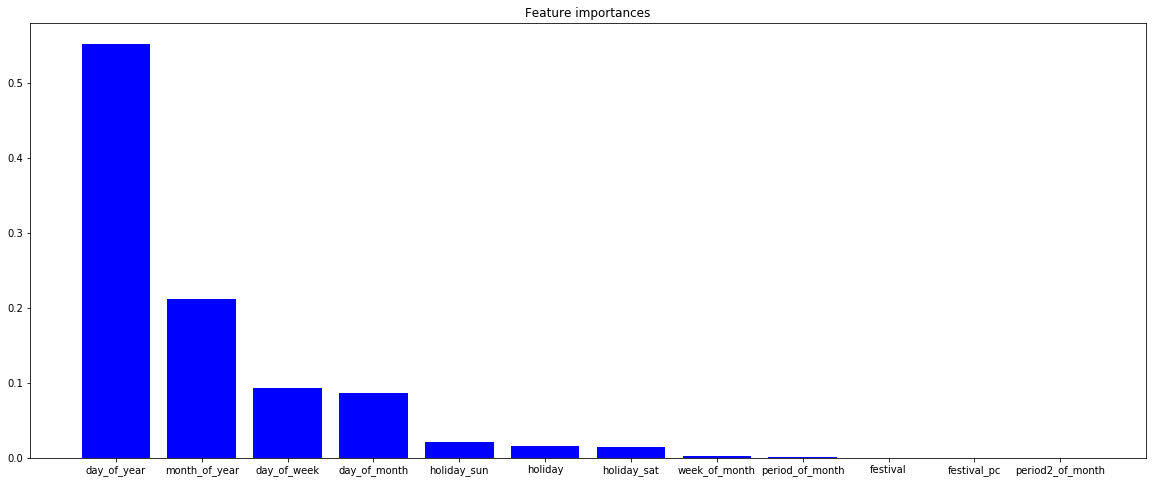

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
print("Feature ranking:")
feature_names = [u'day_of_week', u'day_of_month', u'day_of_year', u'month_of_year',
       u'holiday', u'holiday_sat', u'holiday_sun', u'week_of_month',
       u'period_of_month', u'period2_of_month', u'festival_pc', u'festival']
feature_importances = breg.feature_importances_
indices = np.argsort(feature_importances)[::-1]

for f in indices:
    print("feature %s (%f)" % (feature_names[f], feature_importances[f]))

plt.figure(figsize=(20,8))
plt.title("Feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices],
       color="b",align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices])
plt.xlim([-1, train_X.shape[1]])
plt.show()

### 对10月份进行预测

In [33]:
from datetime import datetime 

def dataprocess(t):
    t = str(t)[0:10]
    time = datetime.strptime(t, '%Y-%m-%d')
    res = time.strftime('%Y%m%d')
    return res

commit_df = pd.date_range('2016/10/1', periods=31, freq='D')
commit_df = pd.DataFrame(commit_df)
commit_df.columns = ['predict_date']
prediction = breg.predict(test_X)
commit_df['predict_power_consumption'] = pd.DataFrame(prediction).astype('int')
commit_df['predict_date'] = commit_df['predict_date'].apply(dataprocess)

commit_df.head()

,predict_date,predict_power_consumption
0,20161001,3748691
1,20161002,3557111
2,20161003,3819058
3,20161004,3819058
4,20161005,3819058


### GradientBoostingDecisionTree

我们用xgboost这个工具库来完成建模，这是一个非常强大的GBM(Gradient Boosting Machine)集成模型库，速度也比较快。
下面是使用这个库建模和调参的一个模板，大家可以参考一下。

In [34]:
# 导入所需的库
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

# 取出建模所用的训练数据矩阵和目标y
X = train_X.values
y = train_y.values

# 候选参数，用于参数调优
param_grid = {
              'max_depth': [3, 4, 5, 7, 9],
              'n_estimators': [20, 40, 50, 80, 100, 200, 400, 800, 1000, 1200],
              'learning_rate': [0.05, 0.1, 0.2, 0.3],
              'subsample': [0.8, 1],
              'colsample_bylevel':[0.8, 1]
             }

# 使用xgboost的regressor完成回归
xgb_model = xgb.XGBRegressor()
# 数据拟合
rgs = GridSearchCV(xgb_model, param_grid, n_jobs=8)
rgs.fit(X, y)

print(rgs.best_score_)
print(rgs.best_params_)

-0.249983577326
{'n_estimators': 20, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 3, 'colsample_bylevel': 0.8}


### 进行预测

In [35]:
from datetime import datetime 

def dataprocess(t):
    t = str(t)[0:10]
    time = datetime.strptime(t, '%Y-%m-%d')
    res = time.strftime('%Y%m%d')
    return res

commit_df = pd.date_range('2016/10/1', periods=31, freq='D')
commit_df = pd.DataFrame(commit_df)
commit_df.columns = ['predict_date']
prediction = rgs.predict(test_X.values)
commit_df['predict_power_consumption'] = pd.DataFrame(prediction).astype('int')
commit_df['predict_date'] = commit_df['predict_date'].apply(dataprocess)

commit_df.head()

,predict_date,predict_power_consumption
0,20161001,3085395
1,20161002,3010870
2,20161003,3390123
3,20161004,3390123
4,20161005,3696733


In [45]:
xgb_model = xgb.XGBRegressor(n_estimators=20, subsample=1, learning_rate=0.3, max_depth=3, colsample_bylevel=0.8)
xgb_model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

### 特征重要度(归因)

Feature ranking:
feature day_of_year (0.508333)
feature day_of_month (0.233333)
feature day_of_week (0.125000)
feature month_of_year (0.108333)
feature holiday (0.016667)
feature week_of_month (0.008333)
feature festival (0.000000)
feature festival_pc (0.000000)
feature period2_of_month (0.000000)
feature period_of_month (0.000000)
feature holiday_sun (0.000000)
feature holiday_sat (0.000000)


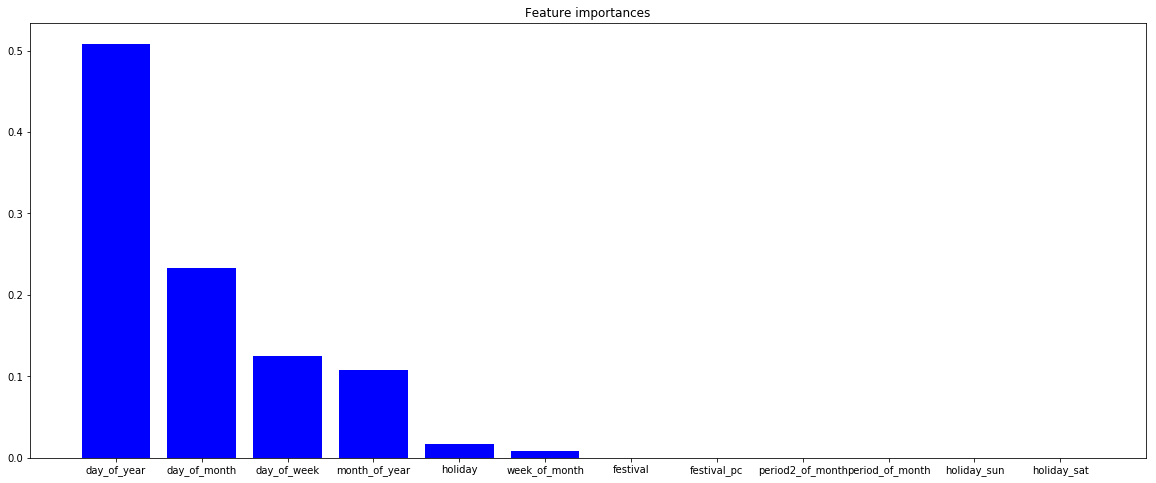

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
print("Feature ranking:")
feature_names = [u'day_of_week', u'day_of_month', u'day_of_year', u'month_of_year',
       u'holiday', u'holiday_sat', u'holiday_sun', u'week_of_month',
       u'period_of_month', u'period2_of_month', u'festival_pc', u'festival']
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

for f in indices:
    print("feature %s (%f)" % (feature_names[f], feature_importances[f]))

plt.figure(figsize=(20,8))
plt.title("Feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices],
       color="b",align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices])
plt.xlim([-1, train_X.shape[1]])
plt.show()

### 绘制出前几棵树决策过程

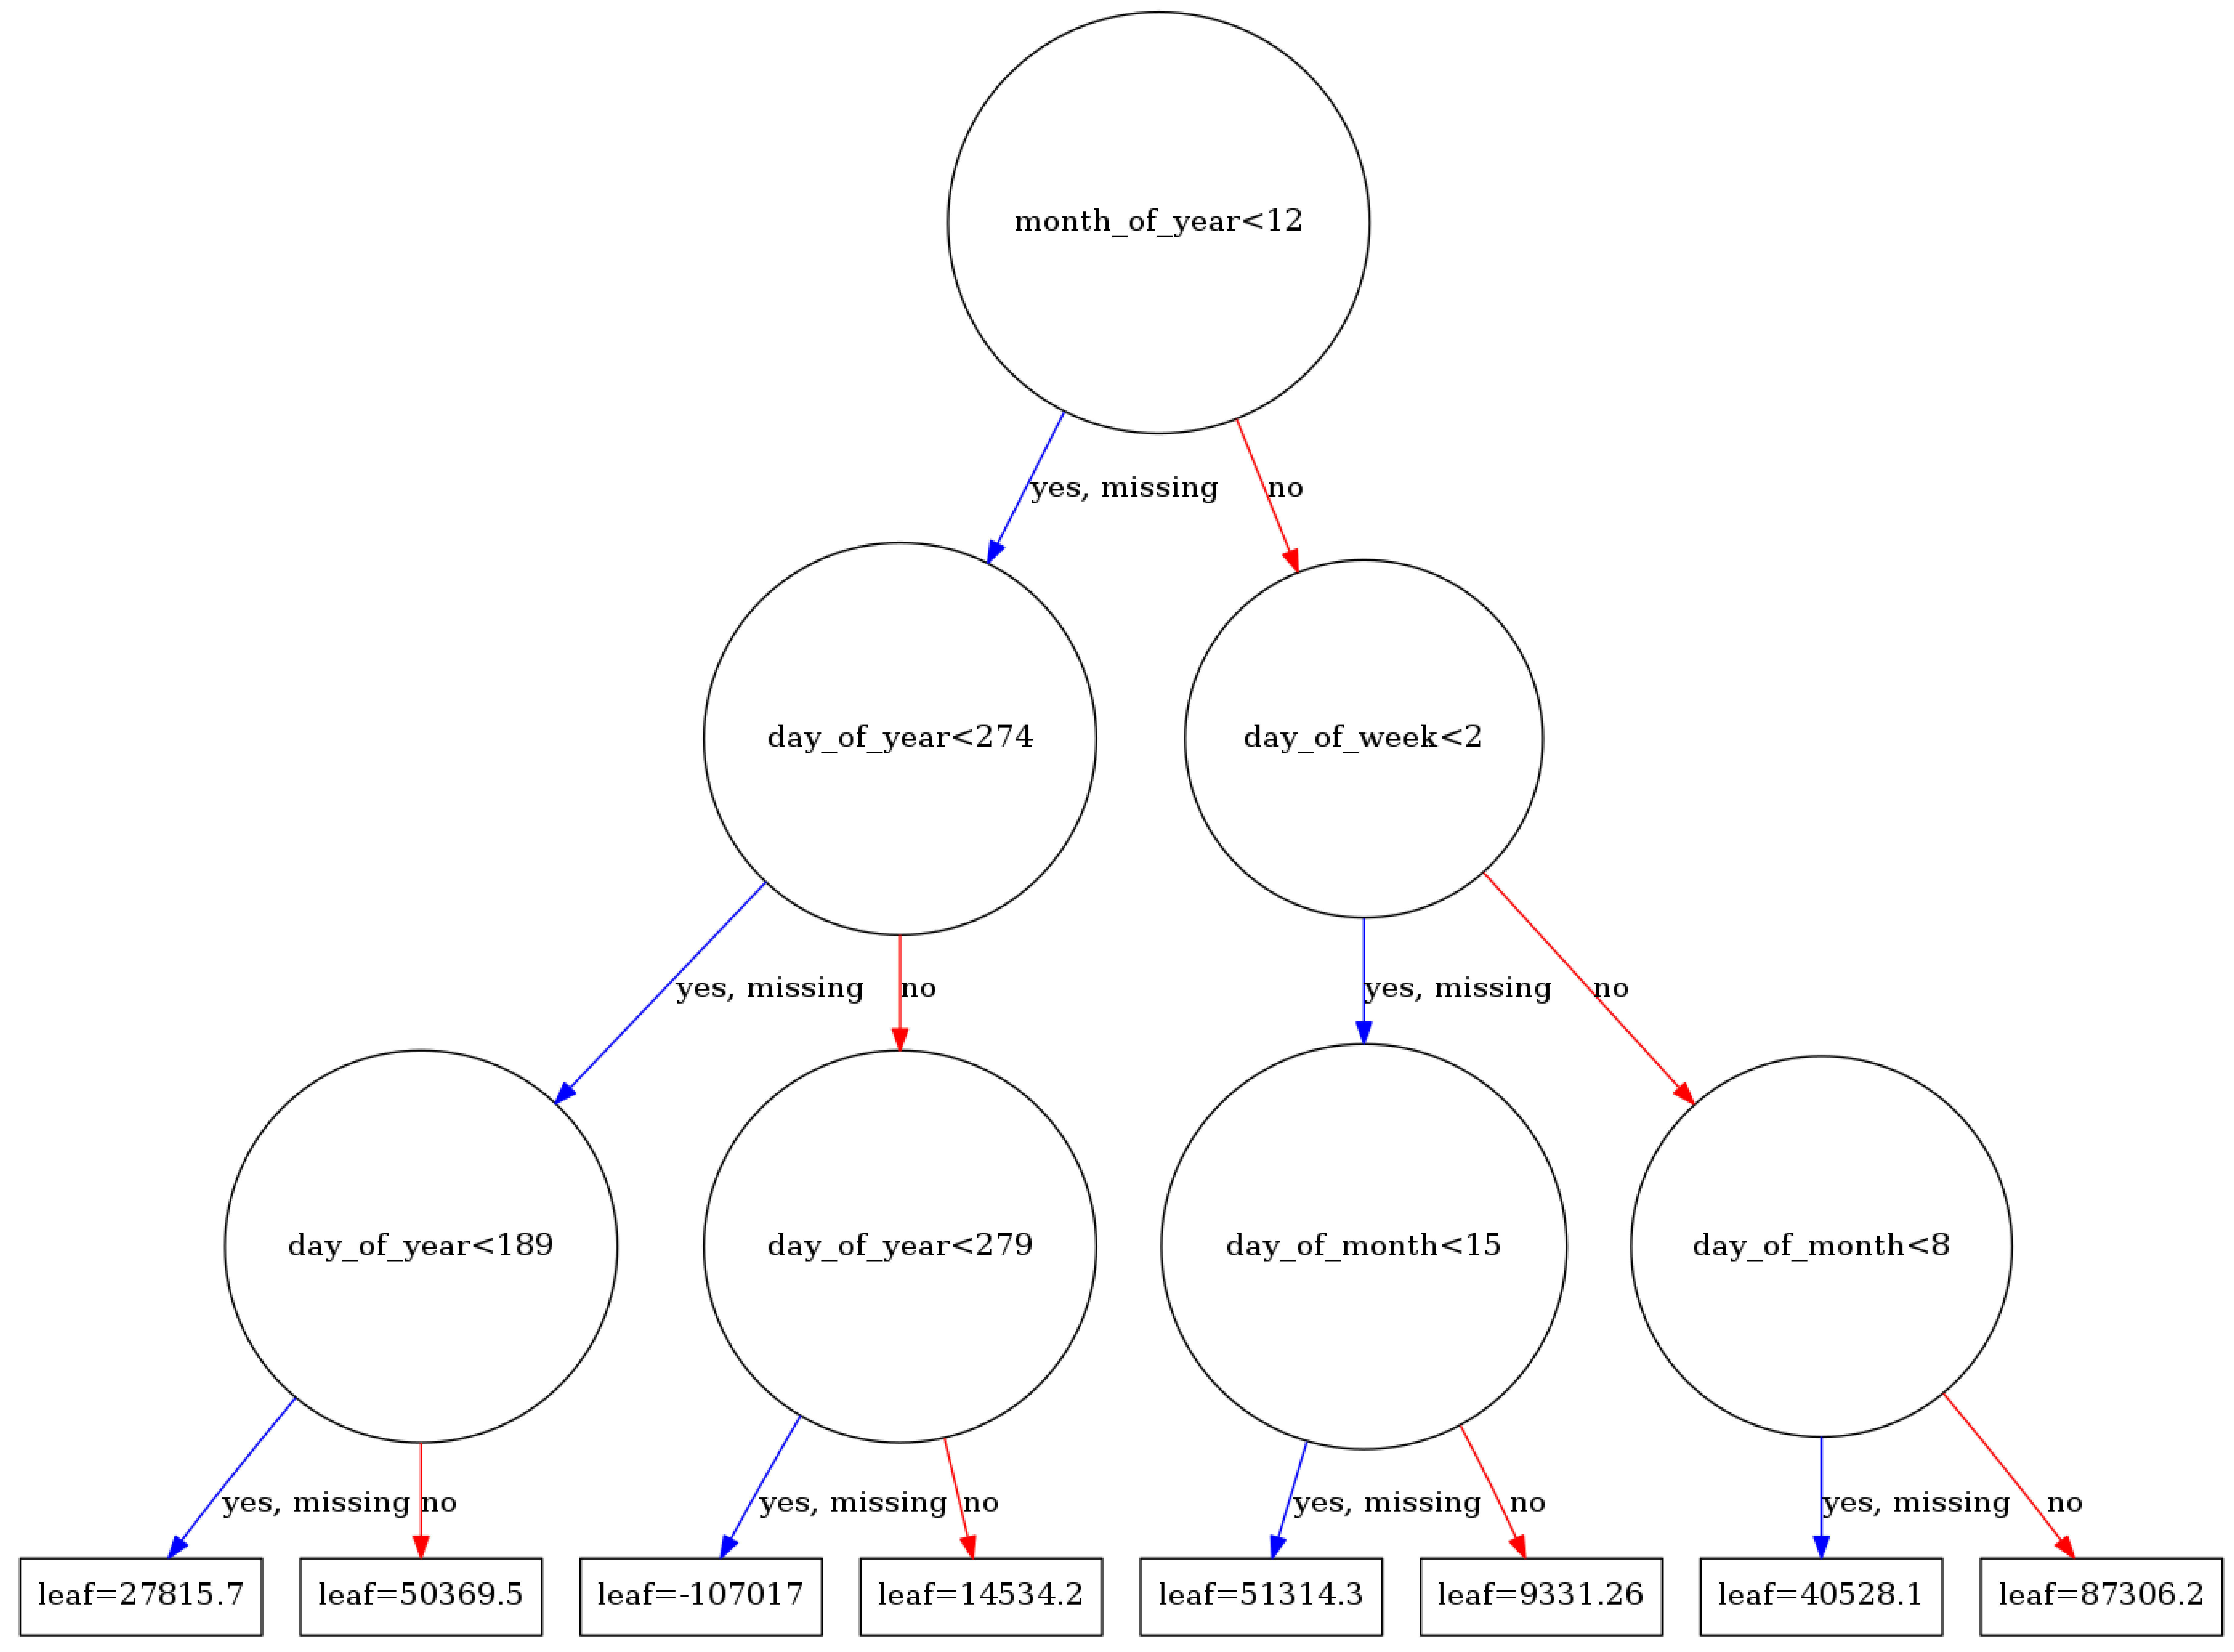

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
xgb.plot_tree(xgb_model, num_trees=10)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')